## 1a. 
> What is a nice formula for the broken line in the parallel prefix curve?

$\frac{p}{\text{floor}\ [2 (\log_2 (p)) - 1]}$

In [1]:
using PyPlot

INFO: Loading help data...


In [2]:
function speedup(p)
    p ./ floor(2 * log2(p) - 1)
end


speedup (generic function with 1 method)

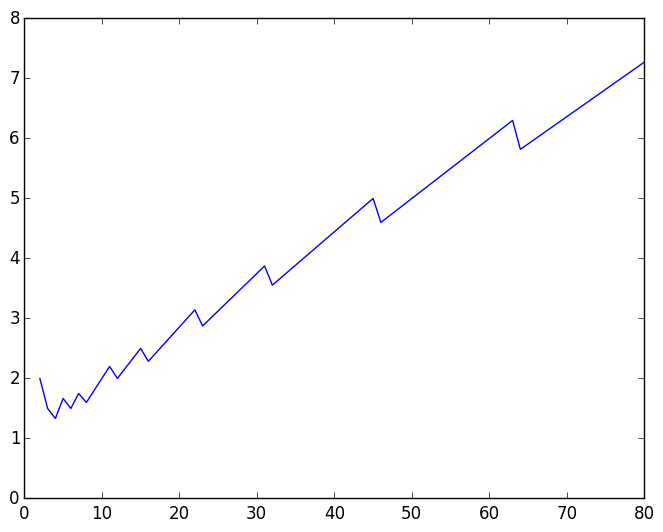

(0,8)

In [3]:
p = 2:80
plot(p, speedup(p))
ylim([0,8])

## 1b. 
> Can you roughly explain the formula?  (Not a formal proof)

The parallel prefix produces a structure with $\text{floor}\ [2 (\log_2 (p)) - 1]$ layers of computation. Within a layer, all computations are independent and can thus be distributed and solved simulataneously across the parallel processors. So the parallel prefix implementation should require $\text{floor}\ [2 (\log_2 (p)) - 1]$ steps. An equivalent serial computation would require $p$ sequential operations. Thus, the speedup is  $\frac{p}{\text{floor}\ [2 (\log_2 (p)) - 1]}$

## 2.

> The exclusive prefix computes the "sum" of every number but yourself. ($y_i = \sum_{j\ne i}x_j$) <br>
Here sum is general, and there is no concept of subtraction.  Write a recursive function similar to the
one in lecture 3, that computes the exclusive prefix.  Give an example why this would be preferred over
subtraction.

First, let's define the obvious versions of the exclusive sum and product, so we can test with them later. 

In [4]:
function exclusive_sum_serial(x)
    # Simple version for testing
    y = zeros(x)
    for i in 1:length(x)
        for j in 1:length(x)
            if i != j
                y[i] += x[j]
            end
        end
    end
    y
end

exclusive_sum_serial (generic function with 1 method)

In [5]:
@assert(all(exclusive_sum_serial([1,2,3,4]) == [9, 8, 7, 6]))

In [6]:
function exclusive_product_serial(x)
    # Simple version for testing
    y = ones(x)
    for i in 1:length(x)
        for j = 1:length(x)
            if i != j
                y[i] *= x[j]
            end
        end
    end
    y
end

exclusive_product_serial (generic function with 1 method)

In [7]:
@assert(all(exclusive_product_serial([1,2,3,4]) == [24, 12, 8, 6]))

Now let's define our recursive function

In [8]:
function exclusive_prefix_recursive(x, ⊕, identity=0)
    # exclusive_prefix_recursive: return y such that y[j] is the "sum"
    # over all x[i] where i != j. The "sum" is computed using the provided
    # operator. 
    #
    # x: a 1-dimensional Array
    # ⊕ (\oplus): an associative binary operator
    # identity: the identity element corresponding to operator ⊕
    #   for example, if ⊕ is +, then identity should be 0
    #
    n = length(x)
    if n > 2
        y = x[:]
        w = x[1:2:n]
        for j = 1:floor(n/2)
            w[j] = w[j] ⊕ x[2*j]
        end
        
        w = exclusive_prefix_recursive(w, ⊕, identity)
        for j = 1:length(x)
            y[j] = w[ceil(j/2)]
            if mod(j, 2) == 0
                y[j] = y[j] ⊕ x[j-1]
            elseif j+1 <= length(x)
                y[j] = y[j] ⊕ x[j+1]
            end
        end
    elseif n == 2
        y = reverse(x)
    else 
        # then n == 1
        y = identity
    end
    y
end


exclusive_prefix_recursive (generic function with 2 methods)

Test some easy examples:

In [9]:
@assert(all(exclusive_prefix_recursive([1,2,3,4], +) == [9, 8, 7, 6]))

In [10]:
@assert(all(exclusive_prefix_recursive([1,2,3,4], *, 1) == [24, 12, 8, 6]))

In [11]:
@assert(exclusive_prefix_recursive([1], +) == 0)

In [12]:
@assert(exclusive_prefix_recursive([1], *, 1) == 1)

Now let's make sure it works for inputs which are not powers of 2

In [13]:
for numel in 1:100
    x = randn(numel)
    @assert(all(abs(exclusive_prefix_recursive(x, +, 0) 
                    .- exclusive_sum_serial(x)) .< 1e-9))
end

for numel in 1:100
    x = randn(numel)
    @assert(all(abs(exclusive_prefix_recursive(x, *, 1)
                    .- exclusive_product_serial(x)) .< 1e-9))
end

### When might this be preferred over subtraction?
One case in which the exclusive sum might be preferred is when dealing with floating point arithmetic. While one would expect that that 

$$
(x_1 + x_2) - x_2 = x_1
$$

the roundoff in floating point arithmetic means that such an identity may not hold:

In [14]:
x1 = 1/3
x2 = 1e100
(x1 + x2) - x2 == x1

false

However, the exclusive sum produces the correct result:

In [15]:
y = exclusive_prefix_recursive([x1, x2], +)

2-element Array{Float64,1}:
 1.0e100 
 0.333333

In [16]:
y[2] == x1

true

## 3.
> Write a parallel-style code that computes the carry lookahead addition of Babbage's using only matrix multiply prefix and embarassingly parallel operations.

In [17]:
function to_binary(x::Int, nbits::Int=8)
    # Convert a number to its binary representation as an array
    # of booleans, LSB first. 
    @assert(x < 2^nbits)
    bits = Array(Bool, nbits)
    for i in nbits-1:-1:0
        if x >= 2^i
            bits[i+1] = 1
            x -= 2^i
        else
            bits[i+1] = 0
        end
    end
    bits
end

to_binary (generic function with 2 methods)

In [18]:
function from_binary(bits::Array{Bool, 1})
    x = 0
    for i in 1:length(bits)
        if bits[i]
            x += 2^(i-1)
        end
    end
    x
end

from_binary (generic function with 1 method)

In [19]:
for x = 0:2^8-1
    @assert(from_binary(to_binary(x)) == x)
end

In [20]:
function prefix!(y, +)
    # Taken from the 18.337 course notes, but with the order of operations
    # reversed to give us matrix multiplication in the correct order.
    l=length(y)
    k=iceil(log2(l))
    @inbounds for j=1:k, i=2^j:2^j:min(l, 2^k)              #"reduce"
        y[i] = y[i] + y[i-2^(j-1)]
    end
    @inbounds for j=(k-1):-1:1, i=3*2^(j-1):2^j:min(l, 2^k) #"broadcast"
        y[i] = y[i] + y[i-2^(j-1)]
    end
    y
end

prefix! (generic function with 1 method)

In [21]:
function prefix_lookahead_add(x1::Int, x2::Int)
    # Use matrix multiply prefix to compute the sum of x1 and x2 
    # using carry look-ahead.
    
    
    nbits = ifloor(max(log2(x1), log2(x2),0)) + 1
    x1 = to_binary(x1, nbits)
    x2 = to_binary(x2, nbits)
    
    @assert(length(x1) == length(x2))
    
    # Construct our carry lookahead matrices
    M = map(i -> [x1[i] $ x2[i] x1[i] & x2[i]; 0 1], 1:length(x1))
    
    # Compute their cumulative product
    prefix!(M, *)
    
    # Extract the carry bits from the cumulative product
    carry = map(m -> bool((m * [0; 1])[1]), M)
    
    # Append some zeros to make mapping easier
    x1 = vcat(x1, [false])
    x2 = vcat(x2, [false])
    carry = vcat([false], carry)
    
    # Compute the sum bits using the original data and carry
    sum = map(i->x1[i] $ x2[i] $ carry[i], 1:length(x1))
    from_binary(sum)
end

prefix_lookahead_add (generic function with 1 method)

Now let's test the lookahead adder on inputs from 0-255:

In [22]:
for x1 = 0:2^8-1
    for x2 = 0:2^8-1
        @assert(prefix_lookahead_add(x1, x2) == x1 + x2)
    end
end    
println("passed")

passed
